In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

In [13]:
def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = cv2.imread(os.path.join(directory, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return images

def preprocess_images(images):
    processed_images = []
    for img in images:
        # Apply preprocessing steps such as resizing, normalization, etc.
        # Example:
        img = cv2.resize(img, (256, 256))
        img = img / 255.0  # Normalize pixel values to [0, 1]
        processed_images.append(img)
    return np.array(processed_images)

def preprocess_masks(masks):
    processed_masks = []
    for mask in masks:
        # Apply preprocessing steps such as resizing, normalization, etc.
        # Example:
        mask = cv2.resize(mask, (256, 256))
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Normalize pixel values to [0, 1]
        processed_masks.append(mask)
    return np.array(processed_masks)

In [10]:
data_directory = './BFC/origin/'
images = load_images(data_directory)
preprocessed_images = preprocess_images(images)

In [14]:
masks_directory = './BFC/all_0515/'
masks = load_images(masks_directory)
preprocessed_masks = preprocess_masks(masks)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_images, preprocessed_masks, test_size=0.2, random_state=42
)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

# Define the U-Net architecture
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoding path
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    up1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    concat1 = concatenate([conv2, up1], axis=3)

    conv4 = Conv2D(128, 3, activation='relu', padding='same')(concat1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat2 = concatenate([conv1, up2], axis=3)

    conv5 = Conv2D(64, 3, activation='relu', padding='same')(concat2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
input_shape = (256, 256, 3)
model = unet_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Rest of the code for data preprocessing, training, and evaluation...

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
model.fit(np.array(X_train), np.array(y_train), batch_size=16, epochs=10)

Epoch 1/10
274/274 [==============================] - 451s 2s/step - loss: 0.4448
Epoch 2/10
274/274 [==============================] - 493s 2s/step - loss: 0.4393
Epoch 3/10
274/274 [==============================] - 502s 2s/step - loss: 0.4391
Epoch 4/10
274/274 [==============================] - 495s 2s/step - loss: 0.4389
Epoch 5/10
274/274 [==============================] - 493s 2s/step - loss: 0.4387
Epoch 6/10
274/274 [==============================] - 491s 2s/step - loss: 0.4388
Epoch 7/10
247/274 [==========================>...] - ETA: 48s - loss: 0.4384

In [21]:
loss = model.evaluate(np.array(X_test), np.array(y_test))
print("Test Loss:", loss)

35/35 [==============================] - 30s 861ms/step - loss: 0.4371
Test Loss: 0.4371143579483032


In [24]:
def predict_images(images):
    predicted_masks = []
    for img in images:
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        predicted_mask = model.predict(img)
        predicted_masks.append(predicted_mask.squeeze())
    return predicted_masks

In [25]:
# Predict on new images
new_images_directory = './BFC/'
new_images = load_images(new_images_directory)
preprocessed_new_images = preprocess_images(new_images)
predicted_masks = predict_images(preprocessed_new_images)

TypeError: Invalid shape (1, 256, 256, 3) for image data

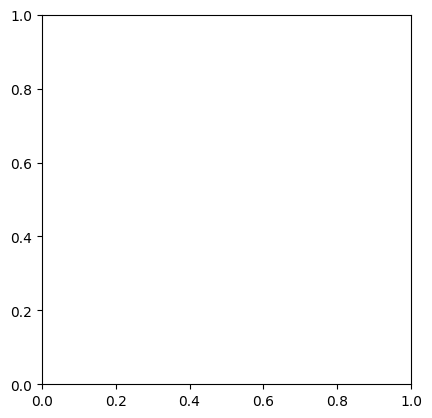

In [29]:
import matplotlib.pyplot as plt
plt.imshow(preprocessed_new_images)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

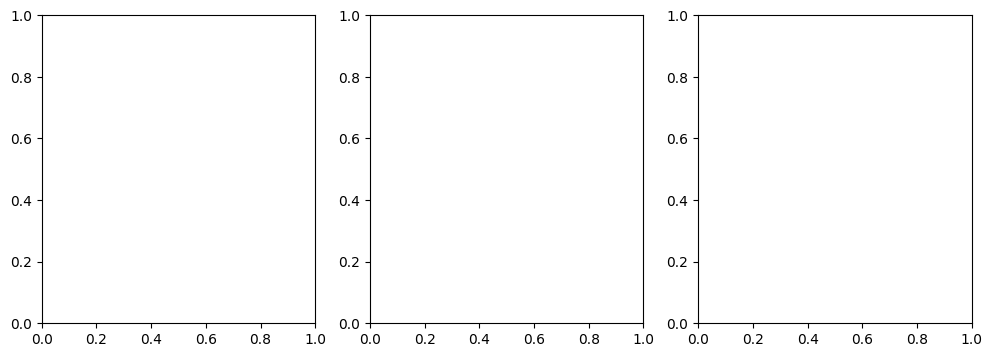

In [32]:
import matplotlib.pyplot as plt

def display_images(images, masks, predicted_masks):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))

    for i in range(num_images):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Input Image')

        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')

        axes[i, 2].imshow(predicted_masks[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()
# Assuming you have preprocessed new images and corresponding masks
new_images_directory = './BFC/'
new_images = load_images(new_images_directory)
preprocessed_new_images = preprocess_images(new_images)

predicted_masks = predict_images(preprocessed_new_images)

display_images(new_images, preprocessed_masks, predicted_masks)


In [26]:
predicted_masks

[array([[0.22619775, 0.13202798, 0.11562875, ..., 0.1154024 , 0.13774818,
         0.24599266],
        [0.17433506, 0.08822823, 0.07279125, ..., 0.07503143, 0.08950359,
         0.17312181],
        [0.17140952, 0.08235458, 0.06858253, ..., 0.07242665, 0.0841108 ,
         0.14664349],
        ...,
        [0.17246664, 0.08578607, 0.07155913, ..., 0.07518992, 0.08241314,
         0.144979  ],
        [0.23171586, 0.13687485, 0.11629963, ..., 0.11922678, 0.12899917,
         0.18897489],
        [0.34747267, 0.25363144, 0.22306821, ..., 0.22938806, 0.22832018,
         0.28251833]], dtype=float32)]

In [ ]:
plt.

In [ ]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoding path
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    up1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    concat1 = concatenate([conv2, up1], axis=3)

    conv4 = Conv2D(128, 3, activation='relu', padding='same')(concat1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat2 = concatenate([conv1, up2], axis=3)

    conv5 = Conv2D(64, 3, activation='relu', padding='same')(concat2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
input_shape = (256, 256, 3)
model = unet_model(input_shape)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

# Define the U-Net architecture
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoding path
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    up1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    concat1 = concatenate([conv2, up1], axis=3)

    conv4 = Conv2D(128, 3, activation='relu', padding='same')(concat1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat2 = concatenate([conv1, up2], axis=3)

    conv5 = Conv2D(64, 3, activation='relu', padding='same')(concat2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
input_shape = (256, 256, 3)
model = unet_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Rest of the code for data preprocessing, training, and evaluation...
